# Image Denoising

We will illustrate a 2D Ising model by creating an image denoiser. The sampling for this method will implement both:
- Gibbs sampling
- Metropolis-Hastings sampling

The image we will use as an example (primarily because it's the most interesting-looking binary image I could think of offhand) is "My Wife and My Mother-in-Law" a classic optical illusion first published in 1915 by William Ely Hill. 

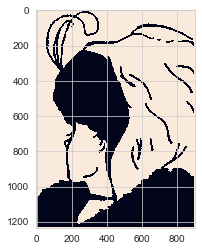

In [97]:
import pandas as pd
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy.special import expit as sigmoid
from scipy.stats import multivariate_normal

np.random.seed(123)
sns.set_style('whitegrid')

data = Image.open('./image.png')
img = np.double(data)
img_mean = np.mean(img)
img_binary = +1*(img>img_mean) + -1*(img<img_mean)
[M, N] = img_binary.shape
plt.imshow(img_binary)

### Corrupting the Image

We now corrupt the image, sampling from a N(0,2) distribution to add noise to the image. 

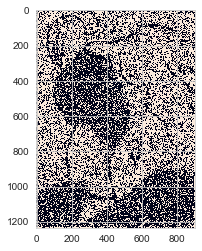

In [98]:
#adding noise
sigma  = 2  #noise level
y = img_binary + sigma*np.random.randn(M, N) 
img_mean = np.mean(y)
y =  +1*(y>img_mean) + -1*(y<img_mean)
y2 = y
plt.imshow(y)

### Metropolis-Hasting Algorithm

The Metropolis-Hasting algorithm is given below. The procedure is as follows:

1. First, we pick a random cell from the grid, labeled $x_{n}$ and consider flipping the state to $-x{n}$
2. We accept this move with probability $\alpha(x'|x) = min\{1,\frac{\pi(x')}{\pi(x)} \frac{Q(x|x')}{Q(x'|x)}\}$
3. For this particular application $\frac{Q(x|x')}{Q(x'|x)} = 1 $ because our proposal distribution is symmetric
4. $\frac{\pi(x')}{\pi(x)} = \exp (-2J(d_{xn}-a_{xn}))$ where $d_{xn}$ is the number of disagreeing edges and $a_{xn}$ is the number of agreeing edges. 



In [99]:
def metropolis_call(grid,spot_x,spot_y,J):
    min_ver = 0 
    max_ver = len(grid[0])
    min_hor = 0 
    max_hor = len(grid)
    value = grid[spot_x][spot_y]
    
    sum = 0 
    
    if(min_ver <= (spot_y - 1)):
        sum = sum + J * grid[spot_x][spot_y-1] * value
    if((spot_y+1) <= max_ver):
        sum = sum + J * grid[spot_x][spot_y+1] * value
    if(min_hor <= (spot_x -1)):
        sum = sum + J * grid[spot_x-1][spot_y] * value 
    if((spot_x + 1) <= max_hor):
        sum = sum + J * grid[spot_x+1][spot_y] * value
    
    
    grid_new = grid
    
    if sum < 0 or (np.random.uniform(0,1) < math.exp(-sum)):
        grid_new[spot_x][spot_y] = -1*value

    return grid_new


def metropolis(grid,J,iter):
    max_ver = len(grid[0])
    max_hor = len(grid)
    grid_new = grid
    
    for i in range(1,iter):      
        x = random.randrange(max_hor - 1)
        y = random.randrange(max_ver - 1)
        grid_new = metropolis_call(grid_new,x,y,J)
    
    return grid_new



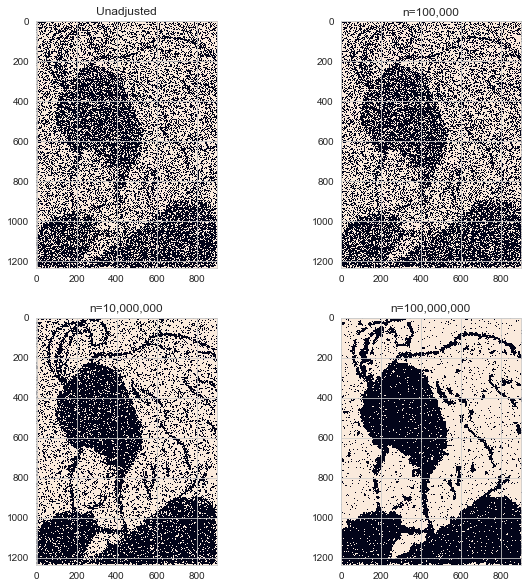

In [89]:

f, axarr = plt.subplots(2,2)
f.set_figheight(10)
f.set_figwidth(10)


axarr[0,0].imshow(y)
axarr[0,0].set_title("Unadjusted")

grid_test1 = metropolis(y,1,100000)
axarr[0,1].set_title("n=100,000")
axarr[0,1].imshow(grid_test1)

grid_test2 = metropolis(y,1,10000000)
axarr[1,0].set_title("n=10,000,000")
axarr[1,0].imshow(grid_test2)

grid_test3 = metropolis(y,1,100000000)
axarr[1,1].set_title("n=100,000,000")
axarr[1,1].imshow(grid_test3)


### Gibbs sampler

The Gibbs sampler is given below. The procedure is as follows:

1. First, we pick a random cell from the grid, labeled $x_{n}$. Denote $x_{-n} = \{x_{1},...,x_{n-1},x_{n+1},...,x_{s}\}$
2. We compute $p(x_{n}|x_{-n}) = \frac{\exp(-Jx_{n}(d_{xn}-a_{xn}))}{\exp(-Jx_{n}(d_{xn}-a_{xn}))+\exp(Jx_{n}(d_{xn}-a_{xn}))}$where $d_{xn}$ is the number of disagreeing edges and $a_{xn}$ is the number of agreeing edges.
3. We then sample $u\sim U(0,1)$ and flip to $-x_{n}$ if $u<p(x_{n}|x_{-n}) $

As you can see, the Gibbs sampler appears to be more efficient for our purposes.

In [101]:
def gibbs_call(grid,spot_x,spot_y,J):
    min_ver = 0 
    max_ver = len(grid[0])
    min_hor = 0 
    max_hor = len(grid)
    value = grid[spot_x][spot_y]
    
    sum = 0 
    
    if(min_ver <= (spot_y - 1)):
        sum = sum + J * grid[spot_x][spot_y-1] * value
    if((spot_y+1) <= max_ver):
        sum = sum + J * grid[spot_x][spot_y+1] * value
    if(min_hor <= (spot_x -1)):
        sum = sum + J * grid[spot_x-1][spot_y] * value 
    if((spot_x + 1) <= max_hor):
        sum = sum + J * grid[spot_x+1][spot_y] * value
    
    
    grid_new = grid
    
    if np.random.uniform(0,1) < math.exp(-sum)/(math.exp(sum)+math.exp(-sum)):
        grid_new[spot_x][spot_y] = -1*value

    return grid_new


def gibbs(grid,J,iter):
    max_ver = len(grid[0])
    max_hor = len(grid)
    grid_new = grid
    
    for i in range(1,iter):      
        x = random.randrange(max_hor - 1)
        y = random.randrange(max_ver - 1)
        grid_new = gibbs_call(grid_new,x,y,J)
    
    return grid_new


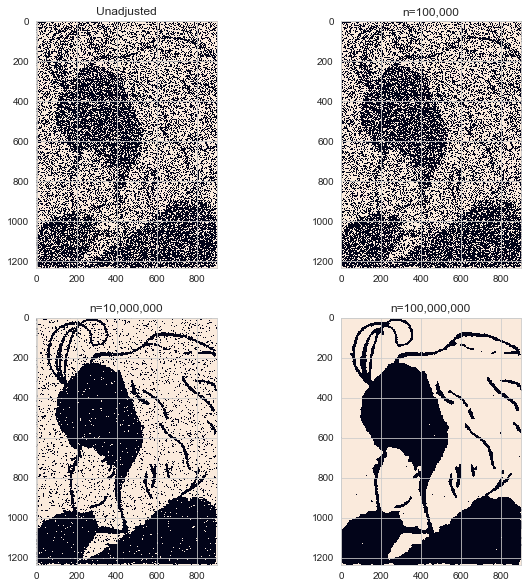

In [102]:

f, axarr = plt.subplots(2,2)
f.set_figheight(10)
f.set_figwidth(10)


axarr[0,0].imshow(y2)
axarr[0,0].set_title("Unadjusted")

grid_test1 = gibbs(y2,1,100000)
axarr[0,1].set_title("n=100,000")
axarr[0,1].imshow(grid_test1)

grid_test2 = gibbs(y2,1,10000000)
axarr[1,0].set_title("n=10,000,000")
axarr[1,0].imshow(grid_test2)

grid_test3 = gibbs(y2,1,100000000)
axarr[1,1].set_title("n=100,000,000")
axarr[1,1].imshow(grid_test3)
